# Pytorch NN with SparkXshards for tabular

Copyright 2016 The BigDL Authors.

SparkXshards in Orca allows users to process large-scale dataset using existing Python codes in a distributed and data-parallel fashion, as shown below. This notebook is an example of how to train a pytorch model using data of SparkXshards on Orca. 

It is adapted from [[TPS-5] Pytorch NN for tabular - step by step](https://www.kaggle.com/code/remekkinas/tps-5-pytorch-nn-for-tabular-step-by-step/notebook)

In [ ]:
# Use seaborn for plots
!pip install seaborn

In [ ]:
# import necessary libraries
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

from bigdl.orca import init_orca_context, stop_orca_context
import bigdl.orca.data.pandas
from bigdl.orca.data.transformer import *
from bigdl.orca.learn.pytorch import Estimator
from bigdl.orca.learn.metrics import Accuracy
import seaborn as sns

In [ ]:
# start an OrcaContext
sc = init_orca_context(cores=4, memory="4g")

## Load data in parallel and get general information

Load data into data_shards, it is a SparkXshards that can be operated on in parallel, here each element of the data_shards is a panda dataframe read from a file on the cluster. Users can distribute local code of `pd.read_csv(dataFile)` using `bigdl.orca.data.pandas.read_csv(datapath)`.

In [ ]:
data_shards = bigdl.orca.data.pandas.read_csv('../train.csv')

In [5]:
# show the first couple of rows in the data_shards
data_shards.head(5)

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,0,1,0,1,0,0,0,0,...,0,0,21,0,0,0,0,0,0,Class_2
1,1,0,0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,2,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,13,2,0,Class_1
3,3,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,1,0,Class_4
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Class_2


In [6]:
# count total number of rows in the data_shards
len(data_shards)

100000

In [7]:
# columns information of element of data_shards.
columns = data_shards.get_schema()['columns']
print(columns)

['id', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'target']


## Assemble feature and labels

In [ ]:
# drop duplicates in the data
data_shards = data_shards.deduplicates()

The labels are in strings. Users can transform the strings into integers using `StringIndexer`

In [ ]:
def change_col_name(df):
    df = df.rename(columns={'id': 'id0'})
    return df
data_shards = data_shards.transform_shard(change_col_name)


encode = StringIndexer(inputCol='target')
data_shards = encode.fit_transform(data_shards)

Labels start from 1 so need to be updated to zero based.

In [ ]:
def update_label_to_zero_base(df):
    df['target'] = df['target'] - 1
    return df
data_shards = data_shards.transform_shard(update_label_to_zero_base)

In [ ]:
def split_train_test(data):
    RANDOM_STATE = 2021
    train, test = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)
    return train, test
train_shards, val_shards = data_shards.transform_shard(split_train_test).split()

Users can call `train_shards.select('target')` to select 'target' data, then call `sample_to_pdf` to bring data cross the cluster to local Pandas Dataframe,  and use seaborn to check the same class representation in the dataset.

     target
160       1
375       0
446       1
305       1
137       1
223       1
323       1
23        1
316       0
424       0


<AxesSubplot:xlabel='target', ylabel='count'>

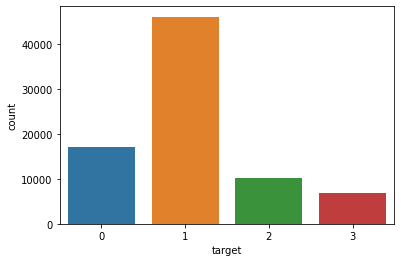

In [12]:
y = train_shards.select("target").sample_to_pdf(frac=1.0)
print(y.head(10))
sns.countplot(x='target', data=y)

Normalize the data

In [ ]:
feature_list = []
for i in range(50):
    feature_list.append('feature_' + str(i))
scale = MinMaxScaler(inputCol=feature_list, outputCol="x_scaled")
train_shards = scale.fit_transform(train_shards)
val_shards = scale.transform(val_shards)

In [ ]:
# Change data types
def change_data_type(df):
    df['x_scaled'] = df['x_scaled'].apply(lambda x: np.array(x, dtype=np.float32))
    df['target'] = df['target'].apply(lambda x: np.long(x))
    return df

train_shards = train_shards.transform_shard(change_data_type)
val_shards = val_shards.transform_shard(change_data_type)

## Define PyTorch model and train it

Users can build a PyTorch model as usual and use Orca Estimator to train it

In [15]:
# define a PyTorch model
torch.manual_seed(0)
BATCH_SIZE = 64
NUM_CLASSES = 4
NUM_EPOCHS = 1
NUM_FEATURES = 50


def linear_block(in_features, out_features, p_drop, *args, **kwargs):
    return nn.Sequential(
        nn.Linear(in_features, out_features),
        nn.ReLU(),
        nn.Dropout(p=p_drop)
    )


class TPS05ClassificationSeq(nn.Module):
    def __init__(self):
        super(TPS05ClassificationSeq, self).__init__()
        num_feature = NUM_FEATURES
        num_class = NUM_CLASSES
        self.linear = nn.Sequential(
            linear_block(num_feature, 100, 0.3),
            linear_block(100, 250, 0.3),
            linear_block(250, 128, 0.3),
        )

        self.out = nn.Sequential(
            nn.Linear(128, num_class)
        )

    def forward(self, x):
        x = self.linear(x)
        return self.out(x)


In [16]:
# define criterion and optimizer
def optim_creator(model, config):
    return optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

In [ ]:
# build Orca Estimator taking a model_creator
def model_creator(config):
    model = TPS05ClassificationSeq()
    print(model)
    return model

est = Estimator.from_torch(model=model_creator, optimizer=optim_creator,
                           loss=criterion, metrics=[Accuracy()], backend="ray")


In [ ]:
# train the model
est.fit(data=train_shards, feature_cols=['x_scaled'], label_cols=['target'],
        validation_data=val_shards, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

In [ ]:
# evaluate the model
result = est.evaluate(data=val_shards, feature_cols=['x_scaled'],
                      label_cols=['target'], batch_size=BATCH_SIZE)

for r in result:
    print(r, ":", result[r])

In [ ]:
# stop OrcaContext
stop_orca_context()